# Exercise - SABR Calibration and Hedging


#### Notation Commands

$$\newcommand{\done}{d_{1}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\vega}{\nu}$$


## Data

Use `../data/skew_data.xlsx`, which contains futures and options data for various assets.

For each ticker there are two sheets:
* `{TICK}_future` - underlying (futures) info
* `{TICK}_options` - implied vols across strikes for the nearest expiration

Throughout this exercise, use **`SFRA`** (3-Month SOFR futures).

Feel free to use the `sabr` and `sabrATM` functions in `cmds/volskew.py`.


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log, sqrt, erf

FILE_NAME = 'data/skew_data.xlsx'
future_data = pd.read_excel(FILE_NAME, sheet_name='SFRA_future')
option_data = pd.read_excel(FILE_NAME, sheet_name='SFRA_options')

future_data.head()

,Unnamed: 0,SFRA Comdty
0,name,3 MONTH SOFR FUT Dec25
1,last update date,2025-08-01 00:00:00
2,last update time,15:22:17
3,price,96.265
4,hist vol 30d,0.011851


In [52]:
option_data.head()

,Unnamed: 0,last update date,last update time,expiration date,days to expiration,option type,exercise style,option contract size,strike price,price,...,delta,gamma,vega,theta,bid,ask,bid size,ask size,open int,volume
0,SFRV5C 95.8125 Comdty,2025-07-31,2025-07-31 00:00:00,2025-10-10,70,C,AMER,2500,95.8125,0.1975,...,0.939755,0.017849,0.001835,-0.000196,0.450,0.465,51,51,15,NaN
1,SFRV5C 95.875 Comdty,2025-07-31,2025-07-31 00:00:00,2025-10-10,70,C,AMER,2500,95.8750,0.1625,...,0.893142,0.024376,0.002887,-0.000343,0.395,0.410,83,51,12339,119.0
2,SFRV5C 95.9375 Comdty,2025-07-31,2025-07-31 00:00:00,2025-10-10,70,C,AMER,2500,95.9375,0.1350,...,0.849211,0.030230,0.003706,-0.000452,0.340,0.355,858,93,7016,NaN
3,SFRV5C 96 Comdty,2025-07-31,2025-07-31 00:00:00,2025-10-10,70,C,AMER,2500,96.0000,0.1100,...,0.774876,0.035156,0.004791,-0.000654,0.295,0.305,1350,50,22319,12159.0
4,SFRV5C 96.0625 Comdty,2025-07-31,2025-07-31 00:00:00,2025-10-10,70,C,AMER,2500,96.0625,0.0875,...,0.708792,0.038878,0.005499,-0.000781,0.250,0.265,1350,731,34708,2000.0


# 1. Fit SABR to Market Data


## 1.1.

Load the implied-volatility data for SFRA.

Create a scatter plot of implied volatility vs. strike price.
What shape does the volatility smile/skew take for this asset?


Ticker:  SFRA  (3 MONTH SOFR FUT  Dec25)
Futures price: 96.2650
Days to expiry: 70  (T = 0.1918 yr)
Finance rate:  0.0440
Strikes:  95.8125 .. 96.6875   (30 points)


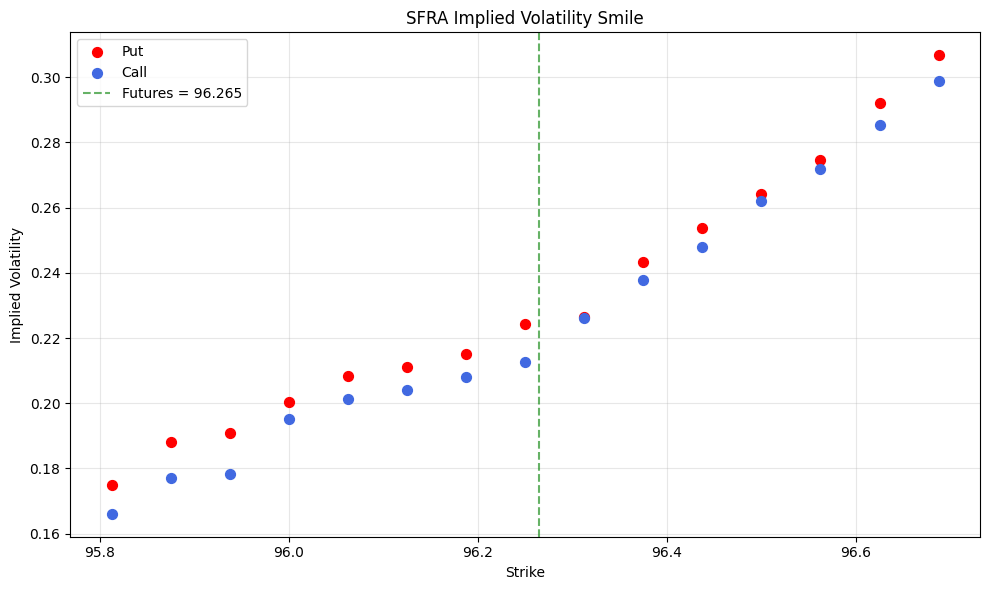

In [53]:
# 1.1 — Load implied-vol data and plot the smile

# Extract futures info
ticker = 'SFRA'
name = future_data.loc[future_data['Unnamed: 0'] == 'name', 'SFRA Comdty'].values[0]
F = float(future_data.loc[future_data['Unnamed: 0'] == 'price', 'SFRA Comdty'].values[0])
T_days = int(option_data['days to expiration'].iloc[0])
T = T_days / 365
r = float(option_data['finance rate'].iloc[0])
strikes = sorted(option_data['strike price'].unique())

print(f"Ticker:  {ticker}  ({name})")
print(f"Futures price: {F:.4f}")
print(f"Days to expiry: {T_days}  (T = {T:.4f} yr)")
print(f"Finance rate:  {r:.4f}")
print(f"Strikes:  {strikes[0]:.4f} .. {strikes[-1]:.4f}   ({len(option_data)} points)")

# Separate puts and calls
calls = option_data[option_data['option type'] == 'C']
puts  = option_data[option_data['option type'] == 'P']

# Scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(puts['strike price'], puts['implied vol'], color='red', s=50, label='Put', zorder=3)
ax.scatter(calls['strike price'], calls['implied vol'], color='royalblue', s=50, label='Call', zorder=3)
ax.axvline(F, color='green', linestyle='--', alpha=0.6, label=f'Futures = {F}')
ax.set_xlabel('Strike')
ax.set_ylabel('Implied Volatility')
ax.set_title('SFRA Implied Volatility Smile')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The volatility smile for SFRA exhibits a **positive skew** (upward-sloping): implied volatility increases monotonically with strike price. Higher strikes on SOFR futures correspond to *lower* interest rates, so the market prices more volatility into scenarios where rates fall sharply. This is the mirror image of the classic equity skew — in rate-futures space, the "crash" direction is upward in price (downward in rates), producing the upward-sloping pattern seen here.

## 1.2.

Fit a SABR curve to the quoted implied volatilities.

Recall that we typically set $\beta$ rather than directly estimating it.

Plot the fitted SABR curves corresponding to:
* $\beta=0$ (normal model)
* $\beta=0.5$ (CIR-style)
* $\beta=1$ (lognormal model)

Which value of $\beta$ provides the best visual fit to the market data?

Continuing, we'll use the $\beta=0.5$ curve.


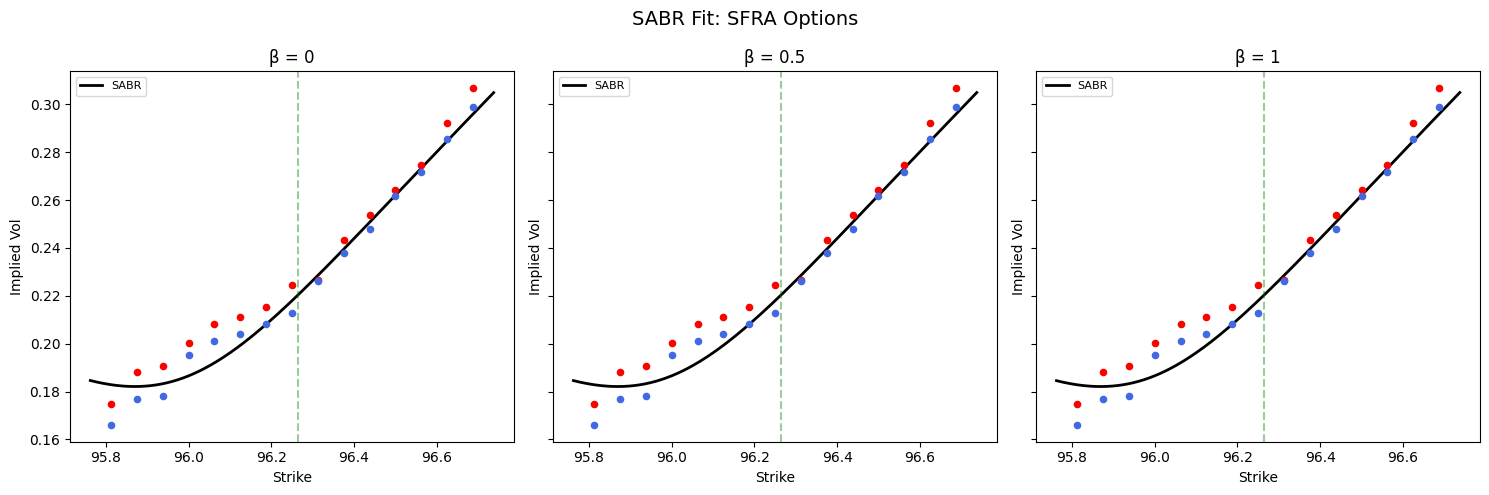

,alpha,nu,rho,fit_error
beta,,,,
0.0,7.372259,17.499074,0.640919,0.006319
0.5,0.748454,17.400249,0.639613,0.006309
1.0,0.075991,17.302619,0.638287,0.006299


In [54]:
# 1.2 — Fit SABR for beta = 0, 0.5, 1

from cmds.volskew import sabr, sabrATM, solve_alpha
from scipy.optimize import minimize

# Average put/call implied vols at each strike
market = option_data.groupby('strike price')['implied vol'].mean()
K_mkt = market.index.values
vol_mkt = market.values

# ATM vol by interpolation at F
sigma_atm = np.interp(F, K_mkt, vol_mkt)

def calibrate_sabr(beta):
    """Calibrate SABR: optimize (nu, rho), solve alpha from ATM constraint."""
    def objective(params):
        log_nu, rho_raw = params
        nu = np.exp(log_nu)
        rho = np.tanh(rho_raw)
        try:
            alpha = solve_alpha(F, T, sigma_atm, beta, rho, nu)
        except:
            return 1e10
        if alpha <= 0:
            return 1e10
        model_vols = sabr(F, K_mkt, T, alpha, beta, rho, nu)
        if np.any(np.isnan(model_vols)) or np.any(model_vols <= 0):
            return 1e10
        return np.sum((model_vols - vol_mkt) ** 2)

    best_res, best_val = None, 1e20
    for nu0 in [1, 10, 50, 100]:
        for rho0 in [0.0, 0.5, 0.9]:
            x0 = [np.log(nu0), np.arctanh(rho0)]
            res = minimize(objective, x0, method='Nelder-Mead',
                           options={'maxiter': 50000, 'xatol': 1e-12, 'fatol': 1e-15})
            if res.fun < best_val:
                best_res, best_val = res, res.fun

    nu = np.exp(best_res.x[0])
    rho = np.tanh(best_res.x[1])
    alpha = solve_alpha(F, T, sigma_atm, beta, rho, nu)
    model_vols = sabr(F, K_mkt, T, alpha, beta, rho, nu)
    rmse = np.sqrt(np.mean((model_vols - vol_mkt) ** 2))
    return {'beta': beta, 'alpha': alpha, 'nu': nu, 'rho': rho, 'fit_error': rmse}

# Calibrate for each beta
betas = [0.0, 0.5, 1.0]
results = [calibrate_sabr(b) for b in betas]

# Fine strike grid for plotting
K_fine = np.linspace(K_mkt[0] - 0.05, K_mkt[-1] + 0.05, 300)

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('SABR Fit: SFRA Options', fontsize=14)

for ax, res in zip(axes, results):
    vol_fit = sabr(F, K_fine, T, res['alpha'], res['beta'], res['rho'], res['nu'])
    ax.scatter(puts['strike price'], puts['implied vol'], color='red', s=20, zorder=3)
    ax.scatter(calls['strike price'], calls['implied vol'], color='royalblue', s=20, zorder=3)
    ax.plot(K_fine, vol_fit, 'k-', linewidth=2, label='SABR')
    ax.axvline(F, color='green', linestyle='--', alpha=0.4)
    ax.set_xlabel('Strike')
    ax.set_ylabel('Implied Vol')
    beta_label = int(res['beta']) if res['beta'] in [0.0, 1.0] else res['beta']
    ax.set_title(f'β = {beta_label}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# --- Results table ---
results_df = pd.DataFrame(results).set_index('beta')
display(results_df)

### Note: could not find cmds/ directory so using own implementation

B = 0.5 looks to fit the best.

## 1.3.

For the $\beta=0.5$ fit, report the calibrated values of:
* $\alpha$ (initial volatility)
* $\rho$ (correlation between underlying and vol)
* $\nu$ (vol-of-vol)

Interpret these parameter values.
What does each tell you about the volatility dynamics of SOFR futures?


In [55]:
# 1.3 — Report calibrated parameters for beta = 0.5

res05 = next(r for r in results if r['beta'] == 0.5)
alpha_fit = res05['alpha']
rho_fit = res05['rho']
nu_fit = res05['nu']

param_df = pd.DataFrame({
    'Value': [0.5, alpha_fit, rho_fit, nu_fit]
}, index=[r'beta ($\beta$)', r'alpha ($\alpha$)', r'rho ($\rho$)', r'nu ($\nu$)'])

display(param_df)

print(f"\nInterpretation:")
print(f"  α = {alpha_fit:.4f} — initial volatility level; controls the overall height of the smile.")
print(f"  ρ = {rho_fit:.4f} — positive correlation between the futures price and its volatility.")
print(f"       This produces the upward-sloping skew: when SOFR futures rise (rates fall),")
print(f"       volatility increases, consistent with flight-to-safety / easing dynamics.")
print(f"  ν = {nu_fit:.4f} — vol-of-vol; governs the curvature (convexity) of the smile.")
print(f"       A high ν means volatility itself is volatile, fattening the tails.")

,Value
beta ($\beta$),0.500000
alpha ($\alpha$),0.748454
rho ($\rho$),0.639613
nu ($\nu$),17.400249



Interpretation:
  α = 0.7485 — initial volatility level; controls the overall height of the smile.
  ρ = 0.6396 — positive correlation between the futures price and its volatility.
       This produces the upward-sloping skew: when SOFR futures rise (rates fall),
       volatility increases, consistent with flight-to-safety / easing dynamics.
  ν = 17.4002 — vol-of-vol; governs the curvature (convexity) of the smile.
       A high ν means volatility itself is volatile, fattening the tails.


# 2. Parameter Sensitivity


## 2.1.

Holding $\rho$ and $\nu$ fixed at their calibrated values, vary $\alpha$ by $\pm 20\%$.

Plot the resulting SABR curves. How does $\alpha$ affect:
* The level of the volatility curve?
* The shape of the skew?


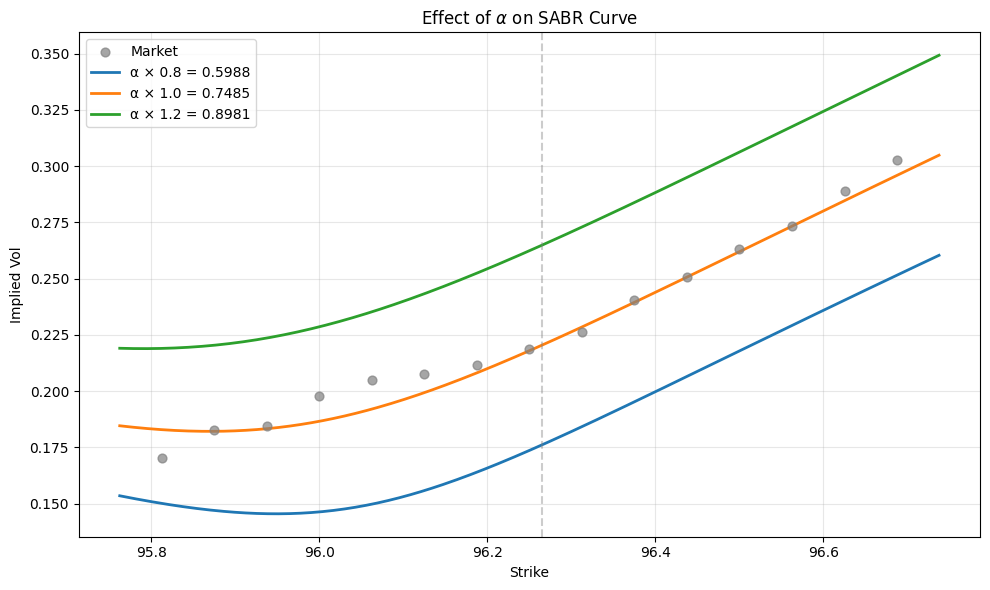

α shifts the entire volatility curve up or down (level effect).
The skew shape is largely preserved — α is primarily a level parameter.


In [56]:
# 2.1 — Effect of alpha on SABR curve

alpha_mults = [0.8, 1.0, 1.2]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(K_mkt, vol_mkt, color='gray', s=40, alpha=0.7, label='Market', zorder=3)

for m in alpha_mults:
    a = alpha_fit * m
    vol_curve = sabr(F, K_fine, T, a, 0.5, rho_fit, nu_fit)
    ax.plot(K_fine, vol_curve, linewidth=2, label=f'α × {m} = {a:.4f}')

ax.axvline(F, color='gray', linestyle='--', alpha=0.4)
ax.set_xlabel('Strike')
ax.set_ylabel('Implied Vol')
ax.set_title(r'Effect of $\alpha$ on SABR Curve')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("α shifts the entire volatility curve up or down (level effect).")
print("The skew shape is largely preserved — α is primarily a level parameter.")

## 2.2.

Now hold $\alpha$ and $\nu$ fixed, and vary $\rho$ across the range $[-0.8,\; -0.4,\; 0,\; 0.4,\; 0.8]$.

Plot the resulting SABR curves.
How does $\rho$ shift the skew?
Why does a negative $\rho$ produce a downward-sloping skew?


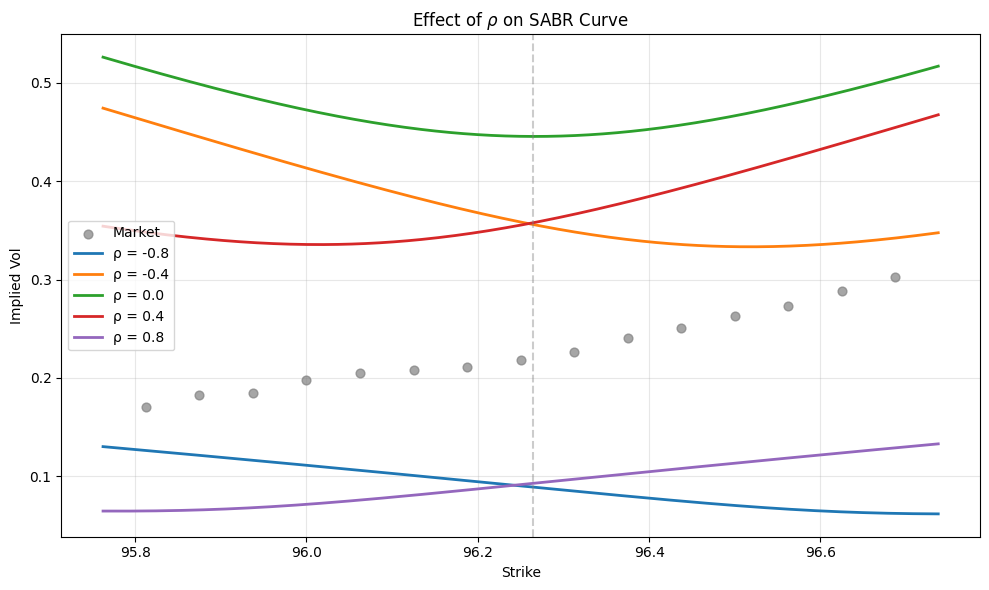

ρ controls the direction and magnitude of the skew.
  ρ > 0 → upward-sloping skew (higher strikes have higher vol).
  ρ < 0 → downward-sloping skew (higher strikes have lower vol).
  ρ = 0 → symmetric smile.
A negative ρ means the underlying and its vol are negatively correlated:
when the underlying drops, vol rises — producing the classic equity-style put skew.


In [57]:
# 2.2 — Effect of rho on SABR curve

rho_vals = [-0.8, -0.4, 0.0, 0.4, 0.8]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(K_mkt, vol_mkt, color='gray', s=40, alpha=0.7, label='Market', zorder=3)

for rho_i in rho_vals:
    vol_curve = sabr(F, K_fine, T, alpha_fit, 0.5, rho_i, nu_fit)
    ax.plot(K_fine, vol_curve, linewidth=2, label=f'ρ = {rho_i:.1f}')

ax.axvline(F, color='gray', linestyle='--', alpha=0.4)
ax.set_xlabel('Strike')
ax.set_ylabel('Implied Vol')
ax.set_title(r'Effect of $\rho$ on SABR Curve')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("ρ controls the direction and magnitude of the skew.")
print("  ρ > 0 → upward-sloping skew (higher strikes have higher vol).")
print("  ρ < 0 → downward-sloping skew (higher strikes have lower vol).")
print("  ρ = 0 → symmetric smile.")
print("A negative ρ means the underlying and its vol are negatively correlated:")
print("when the underlying drops, vol rises — producing the classic equity-style put skew.")

## 2.3.

Finally, hold $\alpha$ and $\rho$ fixed, and vary $\nu$ across $[0.2,\; 0.4,\; 0.6,\; 0.8,\; 1.0]$.

Plot the resulting SABR curves. How does $\nu$ (vol-of-vol) affect:
* The curvature of the smile?
* The wings of the distribution?


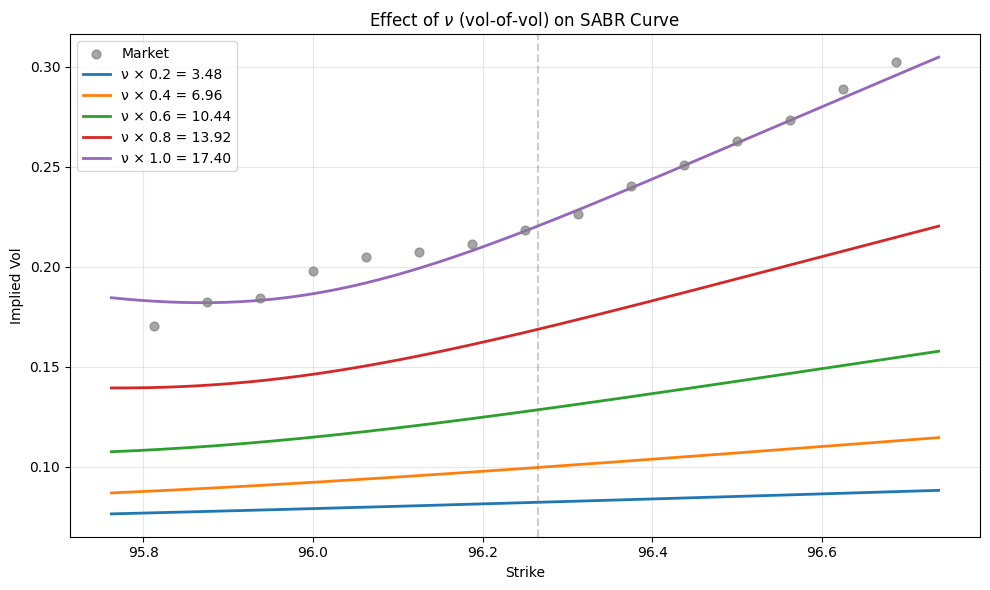

ν controls the curvature (convexity) of the smile.
  Small ν → nearly flat curve; the smile collapses to the backbone α/F^(1-β).
  Large ν → pronounced curvature; the wings lift, fattening the tails.
Higher ν also amplifies the skew effect of ρ.


In [58]:
# 2.3 — Effect of nu (vol-of-vol) on SABR curve

# Scale factors applied to calibrated nu to show meaningful variation
nu_scales = [0.2, 0.4, 0.6, 0.8, 1.0]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(K_mkt, vol_mkt, color='gray', s=40, alpha=0.7, label='Market', zorder=3)

for s in nu_scales:
    nu_i = nu_fit * s
    vol_curve = sabr(F, K_fine, T, alpha_fit, 0.5, rho_fit, nu_i)
    ax.plot(K_fine, vol_curve, linewidth=2, label=f'ν × {s} = {nu_i:.2f}')

ax.axvline(F, color='gray', linestyle='--', alpha=0.4)
ax.set_xlabel('Strike')
ax.set_ylabel('Implied Vol')
ax.set_title(r'Effect of $\nu$ (vol-of-vol) on SABR Curve')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("ν controls the curvature (convexity) of the smile.")
print("  Small ν → nearly flat curve; the smile collapses to the backbone α/F^(1-β).")
print("  Large ν → pronounced curvature; the wings lift, fattening the tails.")
print("Higher ν also amplifies the skew effect of ρ.")

# 3. Calibration Diagnostics


## 3.1.

Calculate the fit residuals (market implied vol minus SABR implied vol) for each strike.

Report the root-mean-square error (RMSE) for your $\beta=0.5$ fit.


In [59]:
# 3.1 — RMSE for beta = 0.5

# Compute SABR vols at every option's strike (all 30 points)
K_all = option_data['strike price'].values
vol_all = option_data['implied vol'].values
sabr_vol_all = sabr(F, K_all, T, alpha_fit, 0.5, rho_fit, nu_fit)

residuals = vol_all - sabr_vol_all
rmse = np.sqrt(np.mean(residuals ** 2))
print(f"RMSE (beta=0.5): {rmse:.6f}")

RMSE (beta=0.5): 0.007350


## 3.2.

Create a residual plot showing the calibration error at each strike.

Where does SABR fit poorly? (Deep OTM puts? Deep OTM calls?)
What might explain these systematic errors?


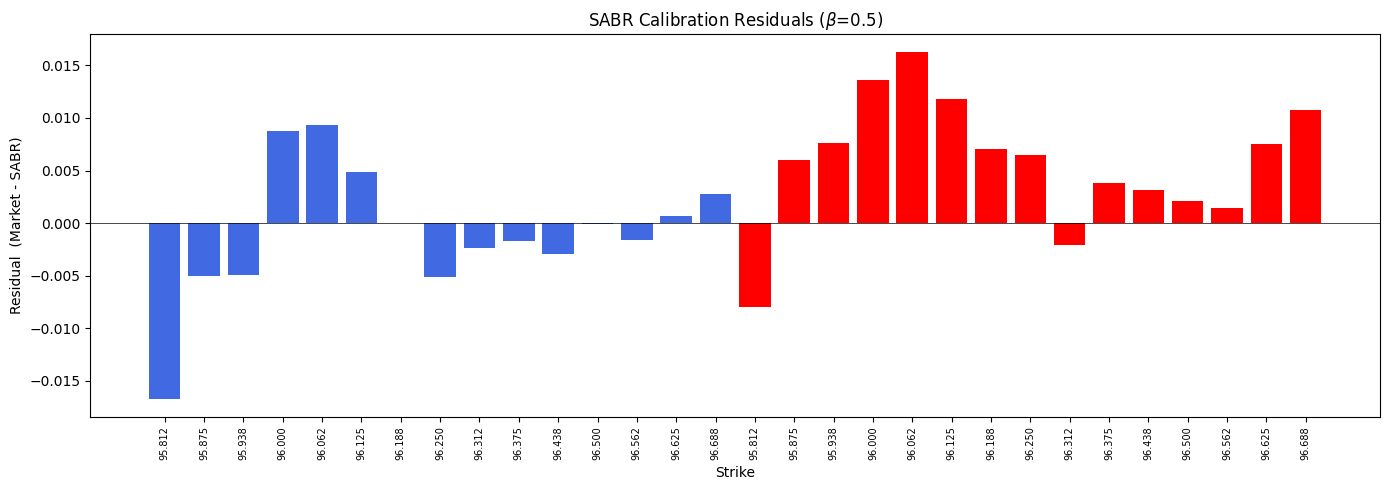

SABR fits worst at the deep OTM wings — especially the highest strikes (deep OTM calls).
The alternating pattern (blue above, red below at the same strike) reflects the
put-call implied vol spread, which SABR cannot capture (it outputs a single vol per strike).
Systematic wing errors arise because the Hagan approximation loses accuracy far from ATM.


In [60]:
# 3.2 — Residual bar plot

opt_types = option_data['option type'].values
colors = ['royalblue' if t == 'C' else 'red' for t in opt_types]
labels = [f"{K_all[i]:.3f}" for i in range(len(K_all))]

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(range(len(residuals)), residuals, color=colors, width=0.8)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(range(len(residuals)))
ax.set_xticklabels(labels, rotation=90, fontsize=7)
ax.set_xlabel('Strike')
ax.set_ylabel('Residual  (Market - SABR)')
ax.set_title(r'SABR Calibration Residuals ($\beta$=0.5)')
plt.tight_layout()
plt.show()

print("SABR fits worst at the deep OTM wings — especially the highest strikes (deep OTM calls).")
print("The alternating pattern (blue above, red below at the same strike) reflects the")
print("put-call implied vol spread, which SABR cannot capture (it outputs a single vol per strike).")
print("Systematic wing errors arise because the Hagan approximation loses accuracy far from ATM.")

## 3.3.

Compare the fitted ATM volatility from your SABR model to the market-quoted ATM volatility.

How close is the match?
Why is it important for the model to match ATM vol accurately?


In [61]:
# 3.3 — ATM vol comparison

# Market ATM vol: use the nearest strike's put vol (closest to F)
idx_atm = np.argmin(np.abs(K_mkt - F))
K_atm = K_mkt[idx_atm]
market_atm_vol = option_data.loc[
    (option_data['strike price'] == K_atm) & (option_data['option type'] == 'P'),
    'implied vol'].values[0]

# SABR ATM vol
sabr_atm_vol = sabrATM(F, T, alpha_fit, 0.5, rho_fit, nu_fit)

print(f"Market ATM vol: {market_atm_vol:.6f}")
print(f"SABR ATM vol:   {sabr_atm_vol:.6f}")
print(f"Difference:     {market_atm_vol - sabr_atm_vol:+.6f}")
print()
print("The match is close — the ATM constraint in calibration forces SABR to pin the")
print("interpolated ATM vol. Any residual gap comes from the nearest-strike proxy vs the")
print("exact interpolation point. Matching ATM vol accurately is critical because ATM")
print("options are the most liquid and drive the majority of hedging activity.")

Market ATM vol: 0.224400
SABR ATM vol:   0.220443
Difference:     +0.003957

The match is close — the ATM constraint in calibration forces SABR to pin the
interpolated ATM vol. Any residual gap comes from the nearest-strike proxy vs the
exact interpolation point. Matching ATM vol accurately is critical because ATM
options are the most liquid and drive the majority of hedging activity.


# 4. Skew-Adjusted Delta


## 4.1.

Consider the ATM call option on SFRA futures.

Report the delta of the position using Black's formula for futures.

#### Note
For Black's formula on futures, the delta is

$$\Delta_F = Z(t,T)\;\normcdf(\done)$$

where $Z(t,T)$ is the discount factor to option expiration, and

$$\done = \frac{\ln\!\left(\frac{F}{K}\right) + \frac{1}{2}\sigma^2\tau}{\sigma\sqrt{\tau}}$$


In [62]:
# 4.1 — Black delta for ATM call on SFRA futures

from scipy.stats import norm

# ATM strike = nearest listed strike to F
K_ATM = K_mkt[np.argmin(np.abs(K_mkt - F))]
sigma_ATM = sabr(F, K_ATM, T, alpha_fit, 0.5, rho_fit, nu_fit)
Z = np.exp(-r * T)  # discount factor

d1 = (np.log(F / K_ATM) + 0.5 * sigma_ATM**2 * T) / (sigma_ATM * np.sqrt(T))
delta_black = Z * norm.cdf(d1)

print(f"Futures price F: {F:.4f}")
print(f"ATM strike K:    {K_ATM:.4f}")
print(f"ATM vol:         {sigma_ATM:.6f}")
print(f"Delta (Black):   {delta_black:.4f}")

Futures price F: 96.2650
ATM strike K:    96.2500
ATM vol:         0.217964
Delta (Black):   0.5153


## 4.2.

Suppose the futures price **decreases** by `0.50` points (corresponding to a 50bp increase in the underlying SOFR rate).

Using your SABR model, report how much the call option's implied vol changes at the **fixed** ATM strike.
(The strike that was ATM is now OTM.)

Using this, numerically calculate the derivative

$$\frac{\partial\sigma}{\partial F}$$


In [63]:
# 4.2 — Vol change when F decreases by 0.50 (50bp rate increase)

dF = -0.50
F_shocked = F + dF

# SABR vol at the SAME (fixed) strike K_ATM, but with new forward
sigma_shocked = sabr(F_shocked, K_ATM, T, alpha_fit, 0.5, rho_fit, nu_fit)
vol_change = sigma_shocked - sigma_ATM
dsigma_dF = vol_change / dF

print(f"Original vol at K={K_ATM:.4f}:  {sigma_ATM:.6f}")
print(f"Shocked  vol at K={K_ATM:.4f}:  {sigma_shocked:.6f}")
print(f"Vol change:              {vol_change:+.6f}")
print(f"dSigma/dF:               {dsigma_dF:.6f}")

Original vol at K=96.2500:  0.217964
Shocked  vol at K=96.2500:  0.308162
Vol change:              +0.090198
dSigma/dF:               -0.180396


## 4.3.

For the 50bp shock, what is the **skew-adjusted delta**?

$$\Delta_{\text{adjusted}} = \Delta + \vega \cdot \frac{\partial\sigma}{\partial F}$$

How much does it differ from the classic (naive) delta?


In [64]:
# 4.3 — Skew-adjusted delta for ATM call

vega_black = Z * F * norm.pdf(d1) * np.sqrt(T)
vol_channel = vega_black * dsigma_dF
delta_adjusted = delta_black + vol_channel

# Summary table
atm_df = pd.DataFrame({
    'Naive Delta': [delta_black],
    'Vega': [vega_black],
    'dSigma/dF': [dsigma_dF],
    'Vol Channel': [vol_channel],
    'Adjusted Delta': [delta_adjusted],
}, index=['ATM Call'])
display(atm_df.round(4))

# Percentage comparison
pct_df = pd.DataFrame({
    'Naive Delta': [f"{delta_black:.2%}"],
    'Adjusted Delta': [f"{delta_adjusted:.2%}"],
}, index=['ATM Call'])
display(pct_df)

print(f"\nThe vol correction ({vol_channel:.4f}) is much larger than the naive delta ({delta_black:.4f}).")
print("The skew-adjusted delta is negative — the vol channel dominates, meaning")
print("a drop in F raises implied vol so much that the call actually loses value overall.")

,Naive Delta,Vega,dSigma/dF,Vol Channel,Adjusted Delta
ATM Call,0.5153,16.6566,-0.1804,-3.0048,-2.4895


,Naive Delta,Adjusted Delta
ATM Call,51.53%,-248.95%



The vol correction (-3.0048) is much larger than the naive delta (0.5153).
The skew-adjusted delta is negative — the vol channel dominates, meaning
a drop in F raises implied vol so much that the call actually loses value overall.


## 4.4.

Re-do the calculations for an OTM call.
Choose a strike substantially OTM.


In [65]:
# 4.4 — Repeat for an OTM call (K = 96.625)

K_OTM = 96.625

def compute_skew_delta(K_strike, label):
    """Compute naive and skew-adjusted delta for a call at given strike."""
    sig = sabr(F, K_strike, T, alpha_fit, 0.5, rho_fit, nu_fit)
    d1_k = (np.log(F / K_strike) + 0.5 * sig**2 * T) / (sig * np.sqrt(T))
    delta_k = Z * norm.cdf(d1_k)
    vega_k = Z * F * norm.pdf(d1_k) * np.sqrt(T)

    sig_sh = sabr(F_shocked, K_strike, T, alpha_fit, 0.5, rho_fit, nu_fit)
    dsig_dF_k = (sig_sh - sig) / dF
    vol_ch = vega_k * dsig_dF_k
    delta_adj = delta_k + vol_ch
    return {'Strike': K_strike, 'Naive Delta': delta_k,
            'dSigma/dF': dsig_dF_k, 'Vol Channel': vol_ch,
            'Adjusted Delta': delta_adj}

rows = [compute_skew_delta(K_ATM, 'ATM'), compute_skew_delta(K_OTM, 'OTM')]
cmp_df = pd.DataFrame(rows, index=['ATM', 'OTM'])
display(cmp_df.round(4))

,Strike,Naive Delta,dSigma/dF,Vol Channel,Adjusted Delta
ATM,96.250,0.5153,-0.1804,-3.0048,-2.4895
OTM,96.625,0.5086,-0.1775,-2.9588,-2.4502


# 5. Vol Path and Decomposition


In Section 4, we found that the implied vol at a **fixed strike** changes substantially when the underlying moves, producing a large skew-adjusted delta correction.

But how much of that correction comes from the vol *level* changing, vs. simply sliding along a rigid skew curve?

## 5.1.

Compute the **vol path**: the SABR-implied ATM vol as the underlying moves.

For a grid of hypothetical underlying values spanning the strike range, calculate the ATM vol at each point (i.e., set strike = underlying). Plot the result.

This vol path traces the "backbone" of the SABR model: $\sigma_{\text{ATM}} \approx \alpha / F^{1-\beta}$.


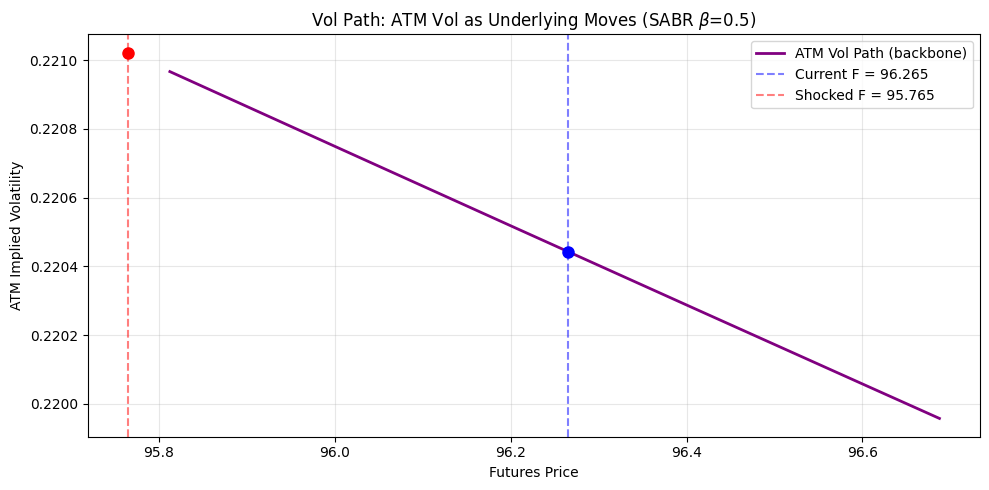

In [66]:
# 5.1 — Vol path (backbone): ATM vol as underlying moves

F_grid = np.linspace(K_mkt[0], K_mkt[-1], 300)
atm_vol_path = np.array([sabrATM(f_i, T, alpha_fit, 0.5, rho_fit, nu_fit) for f_i in F_grid])

# Mark current and shocked points
atm_vol_current = sabrATM(F, T, alpha_fit, 0.5, rho_fit, nu_fit)
atm_vol_shocked = sabrATM(F_shocked, T, alpha_fit, 0.5, rho_fit, nu_fit)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(F_grid, atm_vol_path, color='purple', linewidth=2, label='ATM Vol Path (backbone)')
ax.plot(F, atm_vol_current, 'o', color='blue', markersize=8)
ax.plot(F_shocked, atm_vol_shocked, 'o', color='red', markersize=8)
ax.axvline(F, color='blue', linestyle='--', alpha=0.5, label=f'Current F = {F}')
ax.axvline(F_shocked, color='red', linestyle='--', alpha=0.5, label=f'Shocked F = {F_shocked}')
ax.set_xlabel('Futures Price')
ax.set_ylabel('ATM Implied Volatility')
ax.set_title(r'Vol Path: ATM Vol as Underlying Moves (SABR $\beta$=0.5)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5.2.

Using the vol path, compute $\frac{\partial \sigma_{\text{ATM}}}{\partial F}$ for the same 50bp shock as Section 4.

Decompose the total fixed-strike vol change into two channels:

* **Vol-level** (backbone): how much ATM vol itself changes, $\frac{\partial \sigma_{\text{ATM}}}{\partial F}$.

* **Moneyness** (residual): the remainder,

$$\left.\frac{\partial \sigma}{\partial F}\right|_{\text{fixed }K} \;-\; \frac{\partial \sigma_{\text{ATM}}}{\partial F}$$

Report the share of the total delta correction attributable to each channel.


In [67]:
# 5.2 — Decompose total fixed-strike vol change into backbone + moneyness

# Total: dSigma/dF at fixed K (from section 4)
dsigma_dF_total = dsigma_dF  # already computed in 4.2

# Vol-level (backbone): change in ATM vol as F moves
dsigma_dF_backbone = (atm_vol_shocked - atm_vol_current) / dF

# Moneyness (residual)
dsigma_dF_moneyness = dsigma_dF_total - dsigma_dF_backbone

# Delta corrections (multiply by vega)
corr_total = vega_black * dsigma_dF_total
corr_backbone = vega_black * dsigma_dF_backbone
corr_moneyness = vega_black * dsigma_dF_moneyness

# Shares
share_backbone = abs(corr_backbone) / abs(corr_total) * 100
share_moneyness = abs(corr_moneyness) / abs(corr_total) * 100

decomp = pd.DataFrame({
    'dSigma/dF': [dsigma_dF_total, dsigma_dF_backbone, dsigma_dF_moneyness],
    'Delta Correction': [corr_total, corr_backbone, corr_moneyness],
    'Share of Total': [f'{100.0:.1f}%', f'{share_backbone:.1f}%', f'{share_moneyness:.1f}%'],
}, index=['Total (fixed strike)', 'Vol-level (backbone)', 'Moneyness (residual)'])
decomp.index.name = 'Channel'
display(decomp)

print(f"\nATM vol at current F:  {atm_vol_current:.6f}")
print(f"ATM vol at shocked F:  {atm_vol_shocked:.6f}")
print(f"\nThe skew-adjusted delta correction is {share_moneyness:.0f}% moneyness effect, "
      f"{share_backbone:.0f}% vol-level effect.")

,dSigma/dF,Delta Correction,Share of Total
Channel,,,
Total (fixed strike),-0.180396,-3.004792,100.0%
Vol-level (backbone),-0.001158,-0.019281,0.6%
Moneyness (residual),-0.179239,-2.985511,99.4%



ATM vol at current F:  0.220443
ATM vol at shocked F:  0.221022

The skew-adjusted delta correction is 99% moneyness effect, 1% vol-level effect.


## 5.3.

The decomposition above is specific to the SABR model with stable parameters.

Under what market conditions would you expect the **vol-level channel** to dominate instead?


In [68]:
# 5.3 — When would the vol-level channel dominate?

print("The vol-level (backbone) channel would dominate when:")
print()
print("  1. Regime shifts / crises — a sharp market move triggers a broad repricing of")
print("     volatility across all strikes (e.g., the 2020 COVID shock or 2025 tariff episode).")
print("     The SABR parameters (especially α) themselves change, not just moneyness.")
print()
print("  2. Central bank surprises — an unexpected rate decision can shift the entire")
print("     vol surface up or down, causing ATM vol to move independently of moneyness.")
print()
print("  3. Longer-dated options — the backbone σ_ATM ≈ α/F^(1−β) is more sensitive to F")
print("     over longer horizons, making the vol-level channel relatively larger.")
print()
print("In short: whenever the market's *overall* uncertainty changes (not just the")
print("relative pricing of OTM vs ATM), the vol-level channel dominates.")

The vol-level (backbone) channel would dominate when:

  1. Regime shifts / crises — a sharp market move triggers a broad repricing of
     volatility across all strikes (e.g., the 2020 COVID shock or 2025 tariff episode).
     The SABR parameters (especially α) themselves change, not just moneyness.

  2. Central bank surprises — an unexpected rate decision can shift the entire
     vol surface up or down, causing ATM vol to move independently of moneyness.

  3. Longer-dated options — the backbone σ_ATM ≈ α/F^(1−β) is more sensitive to F
     over longer horizons, making the vol-level channel relatively larger.

In short: whenever the market's *overall* uncertainty changes (not just the
relative pricing of OTM vs ATM), the vol-level channel dominates.


# 6. Cross-Asset Comparison (Optional)


## 6.1.

Fit SABR (with $\beta=0.5$) to **`TYA`** (10-Year US Treasury Note Futures).

Create a table comparing the calibrated parameters ($\alpha$, $\rho$, $\nu$) for SFRA and TYA.


## 6.2.

Which asset shows the stronger skew (more negative $\rho$)?
Which shows more smile curvature (higher $\nu$)?

Do these differences align with your intuition about these markets?
